# <h1> GO/HPO: Scientific Visualization Project

Porcelli Angelica - 78083A

Roveda Gianluca - 73814A

Stefanelli Marta - 84393A

In [1]:
import pandas as pd 

import matplotlib.pyplot as plt
bp = pd.read_csv("gene_go_matrix_propT_rel-is_a-part_of_ont-BP.csv", index_col=0)
cc = pd.read_csv("gene_go_matrix_propT_rel-is_a-part_of_ont-CC.csv", index_col=0)
mf = pd.read_csv("gene_go_matrix_propT_rel-is_a-part_of_ont-MF.csv", index_col=0)


# <h2> 1. Feature Selection

In [ ]:
import pandas as pd

def filter_terms_by_frequency(df, min_freq=2, max_prop=0.20, verbose=True):
    """
    Filtra le colonne (termini) di un DataFrame binario gene×term in base alla frequenza.
    
    Args:
      df: pd.DataFrame, righe = geni, colonne = termini; valori 0/1 o booleani
      min_freq: int, soglia minima (es. rimuovi termini con < min_freq geni annotati)
      max_prop: float, proporzione massima (es. rimuovi termini con > max_prop * n_geni)
      verbose: bool, se True stampa le info
    
    Returns:
      df_filtered: DataFrame con solo i termini che passano il filtro
      dropped: dict con liste dei termini rimossi {"rare": [...], "frequent": [...]}
    """


    df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)

    n_genes = df_bin.shape[0]
    term_freq = df_bin.sum(axis=0)


    max_freq = max_prop * n_genes


    rare_terms = term_freq[term_freq < min_freq].index.tolist()
    frequent_terms = term_freq[term_freq > max_freq].index.tolist()

    if verbose:
        print(f"Numero geni: {n_genes}")
        print(f"Numero termini originali: {df.shape[1]}")
        print(f"Termini troppo rari (< {min_freq}): {len(rare_terms)}")
        print(f"Termini troppo frequenti (> {max_prop*100:.1f}% = {max_freq:.1f} geni): {len(frequent_terms)}")
        print(f"Totale termini da rimuovere: {len(set(rare_terms + frequent_terms))}")

    terms_to_drop = set(rare_terms + frequent_terms)
    df_filtered = df_bin.drop(columns=terms_to_drop)

    if verbose:
        print(f"Terminati: rimangono {df_filtered.shape[1]} termini dopo il filtraggio")

    return df_filtered, {"rare": rare_terms, "frequent": frequent_terms}





In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

def jaccard_sparse(a_idx, b_idx):
    inter = len(np.intersect1d(a_idx, b_idx))
    union = len(a_idx) + len(b_idx) - inter
    return inter / union if union > 0 else 0


def remove_redundant_terms_sparse(df, threshold=0.9, size_tol=0.2):
    print("\n=== RIMOZIONE COLONNE RIDONDANTI ===")
    

    df = df.copy()
    df.insert(0, 'id', range(1, len(df)+1))
    
    print("Converto in matrice sparse...")
    X = csr_matrix(df.values[:, 1:])  

    cols = df.columns[1:].to_list()  
    nnz = np.diff(X.indptr)

    print("Pre-calcolo indice geni annotati per colonna...")
    col_indices = []
    XT = X.T.tocsr()
    for i in range(X.shape[1]):
        start, end = XT.indptr[i], XT.indptr[i+1]
        col_indices.append(XT.indices[start:end])

    to_drop = set()

    print("Inizio confronto Jaccard (scalabile)...")
    for i in range(len(cols)):
        if cols[i] in to_drop:
            continue

        a_idx = col_indices[i]
        a_size = len(a_idx)

        for j in range(i+1, len(cols)):
            if cols[j] in to_drop:
                continue

            b_idx = col_indices[j]
            b_size = len(b_idx)

            if abs(a_size - b_size) / max(a_size, b_size) > size_tol:
                continue

            jac = jaccard_sparse(a_idx, b_idx)
            if jac >= threshold:
                to_drop.add(cols[j])

        if i % 200 == 0:
            print(f"  → Processate {i}/{len(cols)} colonne...")

    print(f"Colonne ridondanti trovate: {len(to_drop)}")
    print(f"Colonne finali: {len(cols) - len(to_drop)}")

    df_clean = df.drop(columns=list(to_drop))
    
    empty_rows = (df_clean.iloc[:, 1:] == 0).all(axis=1)
    n_empty = empty_rows.sum()
    if n_empty > 0:
        print(f"Rimuovo {n_empty} righe totalmente vuote (escludendo id)")
        df_clean = df_clean.loc[~empty_rows]

    return df_clean


In [ ]:
bp_filtered, dropped = filter_terms_by_frequency(bp, min_freq=3, max_prop=0.20)
bp_no_redundancy = remove_redundant_terms_sparse(bp_filtered, threshold=0.9)

mf_filtered, dropped = filter_terms_by_frequency(mf, min_freq=3, max_prop=0.20)
mf_no_redundancy = remove_redundant_terms_sparse(mf_filtered, threshold=0.9)

cc_filtered, dropped = filter_terms_by_frequency(cc, min_freq=3, max_prop=0.20)
cc_no_redundancy = remove_redundant_terms_sparse(cc_filtered, threshold=0.9)

common_ids = set(bp_no_redundancy['id']) & set(mf_no_redundancy['id']) & set(cc_no_redundancy['id'])
print(f"Righe comuni in tutte le tabelle: {len(common_ids)}")

# Filtra le tabelle usando solo gli ID comuni
bp_final = bp_no_redundancy[bp_no_redundancy['id'].isin(common_ids)].copy()
mf_final = mf_no_redundancy[mf_no_redundancy['id'].isin(common_ids)].copy()
cc_final = cc_no_redundancy[cc_no_redundancy['id'].isin(common_ids)].copy()

bp_final.sort_values('id', inplace=True)
mf_final.sort_values('id', inplace=True)
cc_final.sort_values('id', inplace=True)

# Resetta gli indici
bp_final.reset_index(drop=True, inplace=True)
mf_final.reset_index(drop=True, inplace=True)
cc_final.reset_index(drop=True, inplace=True)

C:\Users\gianl\AppData\Local\Temp\ipykernel_15220\1832627117.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)


Numero geni: 5183
Numero termini originali: 9873
Termini troppo rari (< 3): 3461
Termini troppo frequenti (> 20.0% = 1036.6 geni): 26
Totale termini da rimuovere: 3487
Terminati: rimangono 6386 termini dopo il filtraggio

=== RIMOZIONE COLONNE RIDONDANTI ===
Converto in matrice sparse...
Pre-calcolo indice geni annotati per colonna...
Inizio confronto Jaccard (scalabile)...
  → Processate 0/6386 colonne...
  → Processate 200/6386 colonne...
  → Processate 400/6386 colonne...
  → Processate 600/6386 colonne...
  → Processate 800/6386 colonne...
  → Processate 1000/6386 colonne...
  → Processate 1200/6386 colonne...
  → Processate 1400/6386 colonne...
  → Processate 1600/6386 colonne...
  → Processate 1800/6386 colonne...
  → Processate 2000/6386 colonne...
  → Processate 2200/6386 colonne...
  → Processate 2400/6386 colonne...
  → Processate 2600/6386 colonne...
  → Processate 2800/6386 colonne...
  → Processate 3000/6386 colonne...
  → Processate 3200/6386 colonne...
  → Processate 340

C:\Users\gianl\AppData\Local\Temp\ipykernel_15220\1832627117.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)


Numero geni: 5183
Numero termini originali: 3258
Termini troppo rari (< 3): 1843
Termini troppo frequenti (> 20.0% = 1036.6 geni): 8
Totale termini da rimuovere: 1851
Terminati: rimangono 1407 termini dopo il filtraggio

=== RIMOZIONE COLONNE RIDONDANTI ===
Converto in matrice sparse...
Pre-calcolo indice geni annotati per colonna...
Inizio confronto Jaccard (scalabile)...
  → Processate 0/1407 colonne...
  → Processate 200/1407 colonne...
  → Processate 400/1407 colonne...
  → Processate 600/1407 colonne...
  → Processate 800/1407 colonne...
  → Processate 1000/1407 colonne...
  → Processate 1200/1407 colonne...
  → Processate 1400/1407 colonne...
Colonne ridondanti trovate: 70
Colonne finali: 1337
Rimuovo 569 righe totalmente vuote (escludendo id)


C:\Users\gianl\AppData\Local\Temp\ipykernel_15220\1832627117.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)


Numero geni: 5183
Numero termini originali: 1478
Termini troppo rari (< 3): 526
Termini troppo frequenti (> 20.0% = 1036.6 geni): 21
Totale termini da rimuovere: 547
Terminati: rimangono 931 termini dopo il filtraggio

=== RIMOZIONE COLONNE RIDONDANTI ===
Converto in matrice sparse...
Pre-calcolo indice geni annotati per colonna...
Inizio confronto Jaccard (scalabile)...
  → Processate 0/931 colonne...
  → Processate 200/931 colonne...
  → Processate 400/931 colonne...
  → Processate 600/931 colonne...
  → Processate 800/931 colonne...
Colonne ridondanti trovate: 49
Colonne finali: 882
Rimuovo 539 righe totalmente vuote (escludendo id)
Righe comuni in tutte le tabelle: 4166


# <h2> 2. Jaccard Function

In [ ]:
import numpy as np
import pandas as pd
import pyopencl as cl

kernel_code_amd = """
__kernel void jaccard(
    __global const int *mat,
    __global float *out,
    const int n_rows,
    const int n_cols,
    const int row_offset
){
    int i = get_global_id(0) + row_offset;
    int j = get_global_id(1);

    if (i >= n_rows || j >= n_rows)
        return;

    int intersection = 0;
    int uni = 0;

    for (int k = 0; k < n_cols; k++){
        int a = mat[i*n_cols + k];
        int b = mat[j*n_cols + k];

        if (a == 1 || b == 1)
            uni++;

        if (a == 1 && b == 1)
            intersection++;
    }

    if (uni == 0)
        out[i*n_rows + j] = 0.0f;
    else
        out[i*n_rows + j] = (float)intersection / (float)uni;
}
"""

def jaccard_opencl_amd(df, CHUNK=64):
    """
    Calcola la Jaccard similarity su GPU AMD con chunking,
    evitando freeze e saturazione della GPU.
    """
    X = df.values.astype(np.int32)
    n_rows, n_cols = X.shape

    try:
        platforms = cl.get_platforms()
        gpu_devices = []
        for p in platforms:
            for d in p.get_devices(device_type=cl.device_type.GPU):
                if "AMD" in d.vendor:
                    gpu_devices.append(d)

        if len(gpu_devices) == 0:
            raise RuntimeError("No AMD GPU found. Using CPU OpenCL.")

        ctx = cl.Context(devices=[gpu_devices[0]])
    except:
        ctx = cl.create_some_context()

    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags

    X_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=X)
    out_buf = cl.Buffer(ctx, mf.WRITE_ONLY, size=n_rows * n_rows * 4)

    prg = cl.Program(ctx, kernel_code_amd).build()
    kern = cl.Kernel(prg, "jaccard")

    result = np.zeros((n_rows, n_rows), dtype=np.float32)

    for start in range(0, n_rows, CHUNK):
        h = min(CHUNK, n_rows - start)

        kern.set_args(
            X_buf, out_buf,
            np.int32(n_rows),
            np.int32(n_cols),
            np.int32(start)
        )

        cl.enqueue_nd_range_kernel(
            queue, kern,
            (h, n_rows),
            None
        )

        partial_result = np.empty((h, n_rows), dtype=np.float32)
        origin = start * n_rows * 4  # offset in bytes
        cl.enqueue_copy(queue, partial_result, out_buf,
                        device_offset=start*n_rows*4)
        result[start:start+h, :] = partial_result

    return pd.DataFrame(result, index=df.index, columns=df.index)


In [6]:
S_bp  = jaccard_opencl_amd(bp_final,  CHUNK=128)
S_mf = jaccard_opencl_amd(mf_final, CHUNK=128)
S_cc  = jaccard_opencl_amd(cc_final,  CHUNK=128)

C:\Users\gianl\AppData\Local\Temp\ipykernel_15220\2094298569.py:104: DeprecationWarning: The 'device_offset' argument of enqueue_copy is deprecated. Use 'src_offset' instead. 'dst_offset' will stop working in 2023.x.
  cl.enqueue_copy(queue, partial_result, out_buf,


# <h2> 3. TF - IDF

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

def apply_tfidf(df):
    """
    Applica TF-IDF a una matrice binaria GO/HPO mantenendo formato sparso.
    Stampa messaggi di feedback durante l'esecuzione.
    """
    print("=== STEP C: TF-IDF sui termini ===")

    print("conversione del DataFrame in matrice sparse CSR...")
    X = csr_matrix(df.values)
    n_genes, n_terms = X.shape
    print(f"   Matrice: {n_genes} geni × {n_terms} termini")

    print(" frequenza (df_j) dei termini...")
    df_j = np.array(X.sum(axis=0)).ravel()
    print(" Esempio frequenze:")
    print("   - min:", df_j.min(), " max:", df_j.max(), " median:", np.median(df_j))

    print(" IDF = log(N / df_j)...")
    idf = np.log(n_genes / df_j)
    print("   Esempio valori IDF:")
    print("   - min:", idf.min(), " max:", idf.max(), " median:", np.median(idf))


    X_tfidf = X.multiply(idf)
    print("   La matrice finale è ancora sparse.")
    print(f"   Formato: {X_tfidf.shape}, non-zero entries: {X_tfidf.nnz}")

    print("=== TF-IDF COMPLETATO ===\n")

    return X_tfidf, idf


In [ ]:

from scipy.sparse import csr_matrix

X_bp_tfidf, idf_bp = apply_tfidf(bp_final)
X_mf_tfidf, idf_mf = apply_tfidf(mf_final)
X_cc_tfidf, idf_cc = apply_tfidf(cc_final)


bp_dense = X_bp_tfidf.toarray().astype(np.float32)
mf_dense = X_mf_tfidf.toarray().astype(np.float32)
cc_dense = X_cc_tfidf.toarray().astype(np.float32)


from snf import make_affinity

A_bp = make_affinity(bp_dense, K=20)
A_mf = make_affinity(mf_dense, K=20)
A_cc = make_affinity(cc_dense, K=20)


=== STEP C: TF-IDF sui termini ===
→ Converto il DataFrame in matrice sparse CSR...
   Matrice: 4166 geni × 6120 termini
→ Calcolo la frequenza (df_j) dei termini...
   Fatto. Esempio frequenze:
   - min: 0  max: 9984115  median: 9.0
→ Calcolo IDF = log(N / df_j)...
   Fatto. Esempio valori IDF:
   - min: -7.78179426613358  max: inf  median: 6.137487044484698
→ Applico i pesi TF-IDF alle colonne (sparse-safe)...
   Fatto. La matrice finale è ancora sparse.
   Formato: (4166, 6120), non-zero entries: 190668
=== TF-IDF COMPLETATO ===

=== STEP C: TF-IDF sui termini ===
→ Converto il DataFrame in matrice sparse CSR...
   Matrice: 4166 geni × 1338 termini
→ Calcolo la frequenza (df_j) dei termini...
   Fatto. Esempio frequenze:
   - min: 0  max: 9984115  median: 7.0
→ Calcolo IDF = log(N / df_j)...
   Fatto. Esempio valori IDF:
   - min: -7.78179426613358  max: inf  median: 6.3888014727656035
→ Applico i pesi TF-IDF alle colonne (sparse-safe)...
   Fatto. La matrice finale è ancora sparse.

C:\Users\gianl\AppData\Local\Temp\ipykernel_15220\2351736147.py:25: RuntimeWarning: divide by zero encountered in divide
  idf = np.log(n_genes / df_j)
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_

# <h2> 5. Similar Network Function - SNF

In [9]:
from snf import snf
W_fused = snf([A_bp, A_mf, A_cc], K=20, t=10)

c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# <h2> Comparison

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

def compute_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(X)
    return embedding, pca


def compute_tsne(X, n_components=2, perplexity=30, learning_rate=200):
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        init="pca",
        random_state=42
    )
    embedding = tsne.fit_transform(X)
    return embedding, tsne


def compute_umap(X, n_neighbors=30, min_dist=0.1, metric="euclidean"):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )
    embedding = reducer.fit_transform(X)
    return embedding, reducer


c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import hdbscan
from sklearn.cluster import KMeans, AgglomerativeClustering

def cluster_hdbscan(embedding, min_cluster_size=30):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="euclidean"
    )
    labels = clusterer.fit_predict(embedding)
    return labels, clusterer


def cluster_kmeans(embedding, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embedding)
    return labels, kmeans


def cluster_agglomerative(embedding, n_clusters=10):
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg.fit_predict(embedding)
    return labels, agg


In [12]:
def plot_clusters(embedding, labels, title="Cluster Visualization"):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        embedding[:, 0], embedding[:, 1],
        c=labels,
        cmap='tab20',
        s=10
    )
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(scatter)
    plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def find_best_k_by_silhouette(embedding, k_min=2, k_max=20, plot=True):
    """
    Evaluate silhouette scores for different values of k (K-Means)
    and return the best k.
    
    Parameters:
        embedding : array-like, shape (n_samples, n_features)
        k_min : int, minimum number of clusters to test
        k_max : int, maximum number of clusters to test
        plot : bool, if True show silhouette score plot
    
    Returns:
        best_k : int, value of k with highest silhouette score
        scores : dict, mapping k → silhouette score
    """
    
    scores = {}
    
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embedding)
    
        if len(set(labels)) > 1:
            score = silhouette_score(embedding, labels)
            scores[k] = score
        else:
            scores[k] = -1 
    
    best_k = max(scores, key=scores.get)
    
    if plot:
        plt.figure(figsize=(7, 4))
        plt.plot(list(scores.keys()), list(scores.values()), marker='o')
        plt.xlabel("k")
        plt.ylabel("Silhouette Score")
        plt.title("Silhouette Score for Different k (K-Means)")
        plt.grid(True)
        plt.show()
    
    return best_k, scores


c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


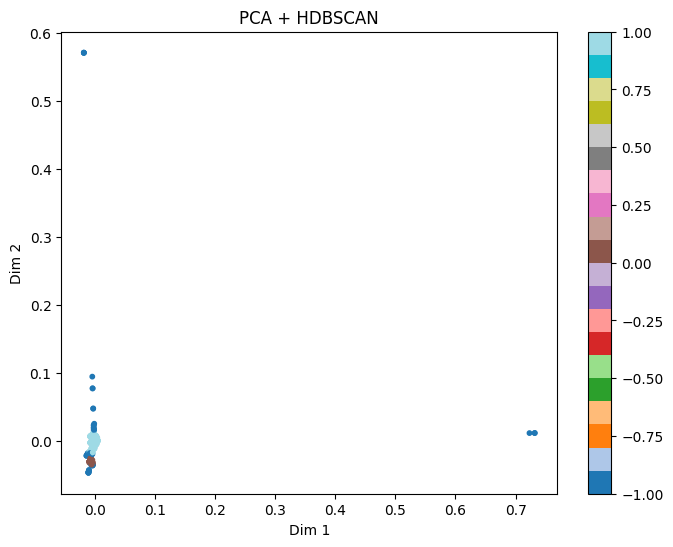

In [15]:
embedding_pca, _ = compute_pca(W_fused)
labels_pca, _ = cluster_hdbscan(embedding_pca)

plot_clusters(embedding_pca, labels_pca, title="PCA + HDBSCAN")


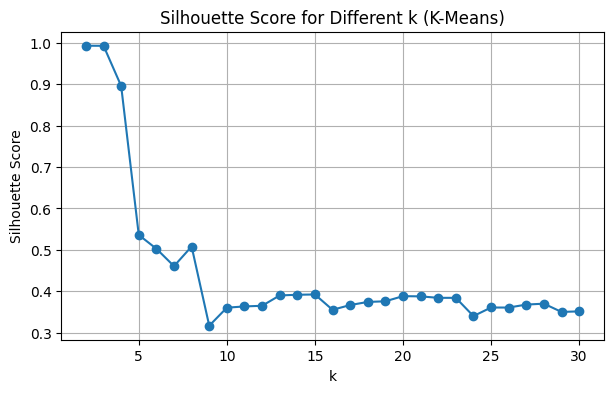

Best k: 2


In [16]:
best_k, scores = find_best_k_by_silhouette(embedding_pca, k_min=2, k_max=30)
print("Best k:", best_k)


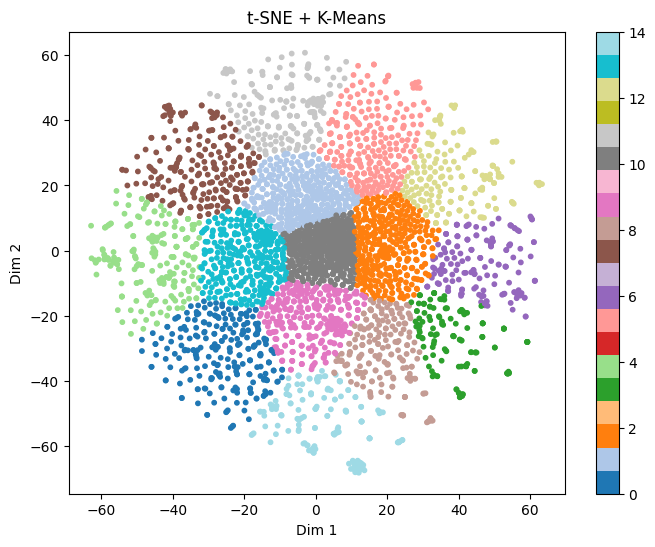

In [17]:
embedding_tsne, _ = compute_tsne(W_fused, perplexity=50)
labels_tsne, _ = cluster_kmeans(embedding_tsne, n_clusters=15)

plot_clusters(embedding_tsne, labels_tsne, title="t-SNE + K-Means")


c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


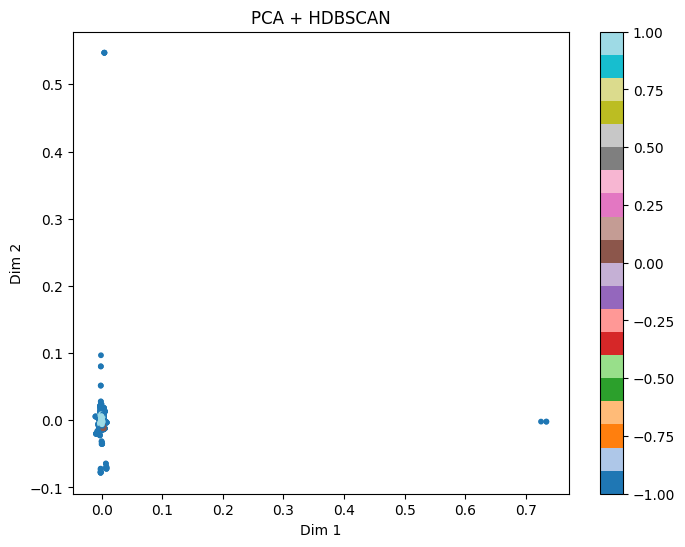

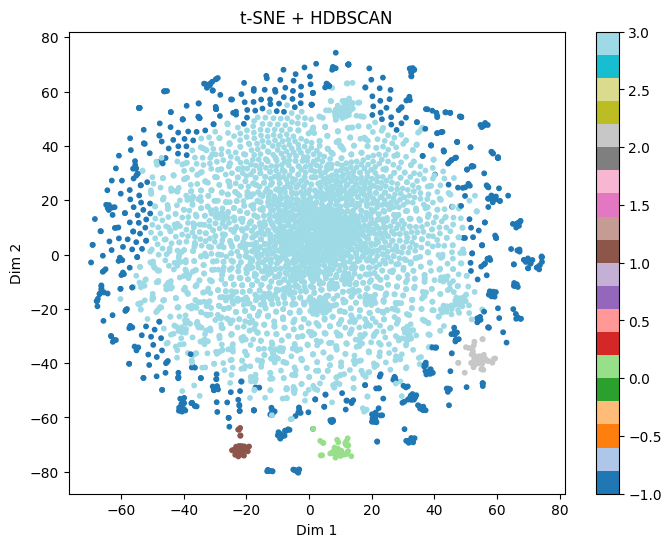

In [18]:
emb_pca, _ = compute_pca(W_fused)
emb_tsne, _ = compute_tsne(W_fused)
labels_pca, _ = cluster_hdbscan(emb_pca)
labels_tsne, _ = cluster_hdbscan(emb_tsne)
plot_clusters(emb_pca, labels_pca, "PCA + HDBSCAN")
plot_clusters(emb_tsne, labels_tsne, "t-SNE + HDBSCAN")


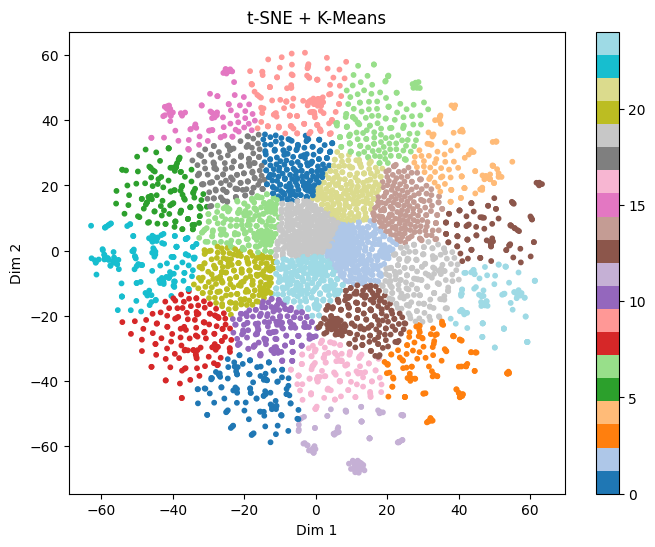

In [19]:
embedding_tsne, _ = compute_tsne(W_fused, perplexity=50)
labels_tsne, _ = cluster_kmeans(embedding_tsne, n_clusters=25)

plot_clusters(embedding_tsne, labels_tsne, title="t-SNE + K-Means")


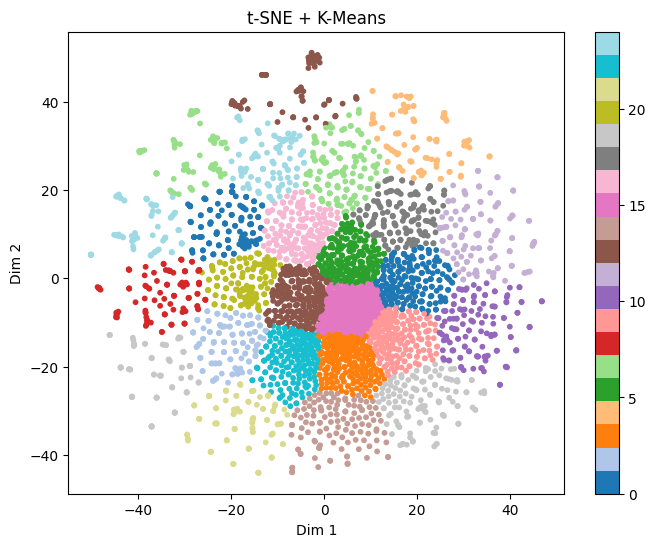

In [20]:
embedding_tsne, _ = compute_tsne(W_fused, perplexity=70)
labels_tsne, _ = cluster_kmeans(embedding_tsne, n_clusters=25)

plot_clusters(embedding_tsne, labels_tsne, title="t-SNE + K-Means")


# <h2> 6. HDBSCAN & UMAP Clustering

c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


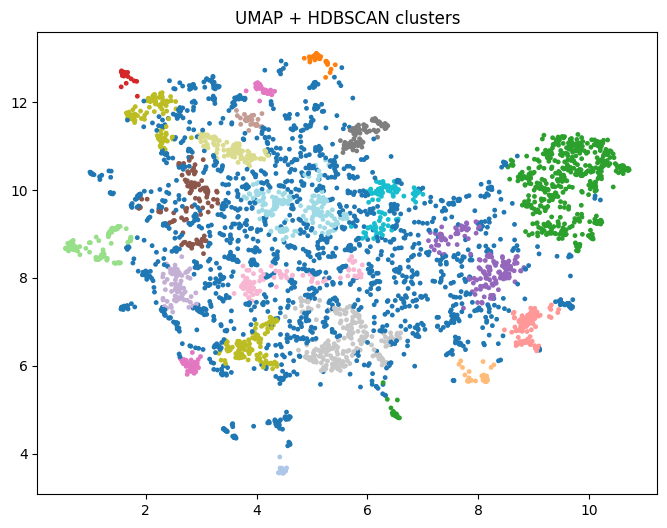

In [ ]:
import umap
import numpy as np
import umap.umap_ as umap

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

embedding = umap_model.fit_transform(W_fused)

import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    metric="euclidean"
)

labels = clusterer.fit_predict(embedding)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:,0], embedding[:,1],
            c=labels,
            cmap='tab20',
            s=6)
plt.title("UMAP + HDBSCAN clusters")
plt.show()

In [ ]:
import umap
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


def umap_hdbscan_from_affinity(W_fused, gene_labels=None,
                               n_neighbors=30, min_dist=0.1,
                               metric="cosine", random_state=42,
                               interactive=True):
    """
    UMAP + HDBSCAN applicato a una matrice di affinità già fusa (W_fused).
    
    Argomenti:
        W_fused: matrice (n_geni × n_geni) ottenuta da SNF
        gene_labels: annotazioni opzionali (nomi geni) per hover
        n_neighbors, min_dist: parametri UMAP
        metric: metrica UMAP (default: cosine)
        interactive: se True → plot Plotly, altrimenti Matplotlib
        
    Ritorna:
        embedding: (n_geni × 2)
        cluster_labels: etichette HDBSCAN
    """

    print("=== STEP D: UMAP embedding + HDBSCAN clustering (da W_fused) ===")
    print(f"Input: matrice fusa {W_fused.shape[0]} × {W_fused.shape[1]}")
    
    print(f"→ Configuro UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}")
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )

    print("→ Fit e trasformazione UMAP su W_fused...")
    embedding = reducer.fit_transform(W_fused)
    print(f"   Embedding shape: {embedding.shape}")
    
    print("→ Eseguo HDBSCAN sullo spazio UMAP...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=30, metric='euclidean')
    cluster_labels = clusterer.fit_predict(embedding)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    print(f"   Cluster trovati: {n_clusters}, punti noise: {n_noise}")

    if interactive:
        df_plot = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Cluster': cluster_labels.astype(str)
        })
        if gene_labels is not None:
            df_plot['Gene'] = gene_labels
        
        fig = px.scatter(
            df_plot, x='UMAP1', y='UMAP2',
            color='Cluster',
            hover_data=['Gene'] if gene_labels is not None else None,
            title='UMAP + HDBSCAN (da W_fused)',
            width=800, height=600
        )
        fig.show()
    else:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                              c=cluster_labels, cmap='tab20',
                              s=10, alpha=0.8)
        plt.title("UMAP + HDBSCAN (da W_fused)")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.colorbar(scatter, label='Cluster')
        plt.grid(True)
        plt.show()
    
    print("=== PIPELINE COMPLETATA ===\n")

    return embedding, cluster_labels


In [ ]:
embedding, labels = umap_hdbscan_from_affinity(
    W_fused,
    gene_labels=bp_final['id'],   
    interactive=True              
)

=== STEP D: UMAP embedding + HDBSCAN clustering (da W_fused) ===
Input: matrice fusa 4166 × 4166
→ Configuro UMAP: n_neighbors=30, min_dist=0.1, metric=cosine
→ Fit e trasformazione UMAP su W_fused...


c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   Embedding shape: (4166, 2)
→ Eseguo HDBSCAN sullo spazio UMAP...
   Cluster trovati: 25, punti noise: 1711
→ Creo plot interattivo con Plotly...


c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


=== PIPELINE COMPLETATA ===



# <h2> 7. Cluster Analysis

In [ ]:
gene_cluster_df = pd.DataFrame({
    'gene_id': bp_final['id'],   
    'cluster': labels
})
gene_cluster_df.to_csv("gene_cluster.csv", index=False)
print("File gene_cluster.csv salvato.")

def top_terms_per_cluster(X_tfidf, labels, term_names, top_k=5):
    unique_clusters = sorted([c for c in set(labels) if c != -1])
    result = {}
    X = X_tfidf.tocsr()
    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue
        cluster_mean = X[idx].mean(axis=0).A1
        top_idx = np.argsort(cluster_mean)[::-1][:top_k]
        terms = [(term_names[i], cluster_mean[i]) for i in top_idx]
        result[c] = terms
    return result

domains = {'BP': (X_bp_tfidf, bp_final.columns),
           'MF': (X_mf_tfidf, mf_final.columns),
           'CC': (X_cc_tfidf, cc_final.columns)}

for dom, (X_tfidf, cols) in domains.items():
    print(f"\n=== Top 5 termini per cluster - {dom} ===")
    top5 = top_terms_per_cluster(X_tfidf, labels, cols, top_k=5)
    for c, terms in top5.items():
        print(f"\nCluster {c}:")
        for t, score in terms:
            print(f"  {t} → {score:.4f}")

File gene_cluster.csv salvato.

=== Top 5 termini per cluster - BP ===

Cluster 0:
  GO.0022900 → 2.9248
  GO.0022904 → 2.8118
  GO.0006119 → 2.7827
  GO.0042775 → 2.7757
  GO.0009060 → 2.6413

Cluster 1:
  GO.0006120 → 4.2788
  GO.0015986 → 3.9989
  GO.0006754 → 3.8521
  GO.0042775 → 3.8399
  GO.0032981 → 3.7884

Cluster 2:
  GO.0045109 → 3.1886
  GO.0045104 → 3.1392
  GO.0031424 → 2.4114
  GO.0030216 → 2.3231
  GO.0043588 → 2.1162

Cluster 3:
  GO.0006412 → 3.1153
  GO.0002181 → 2.5371
  GO.0042254 → 2.0394
  GO.0010467 → 1.6982
  GO.0042274 → 1.5559

Cluster 4:
  GO.0007018 → 3.0868
  GO.0003341 → 3.0337
  GO.0060271 → 2.7585
  GO.0007017 → 2.5894
  GO.0060294 → 2.5777

Cluster 5:
  GO.0006357 → 1.4868
  GO.0045893 → 1.2388
  GO.0045892 → 1.2027
  GO.0045944 → 1.1979
  GO.0000122 → 1.1186

Cluster 6:
  GO.0030001 → 2.3696
  GO.0098655 → 2.3426
  GO.0006812 → 2.1978
  GO.0034220 → 2.1947
  GO.0006811 → 2.0689

Cluster 7:
  GO.0030198 → 3.2002
  GO.0030199 → 1.9028
  GO.0038063 → 1.10

# <h3> Validation of pipeline


In [ ]:
from sklearn.metrics import silhouette_score

def silhouette_umap_snf(embedding, labels):
    unique = set(labels)
    if len(unique) <= 1 or (len(unique) == 2 and -1 in unique):
        print("Silhouette score not valid because only one real cluster exists.")
        return None
    
    mask = labels != -1
    score = silhouette_score(embedding[mask], labels[mask])
    print("Silhouette score UMAP(W_fused) + HDBSCAN:", score)
    return score


In [30]:
silhouette_umap_snf(embedding, labels)


Silhouette score UMAP(W_fused) + HDBSCAN: 0.5587590932846069


0.5587590932846069

# <h3> Cluster Size

In [31]:
np.unique(labels, return_counts=True)


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24]),
 array([1711,   35,   33,   40,   51,   34,  488,  113,   34,  112,  120,
          53,   81,  114,   34,   38,   48,   92,  100,  229,  114,  106,
         104,  102,   93,   87]))

In [32]:
import numpy as np
import pandas as pd

clusters, counts = np.unique(labels, return_counts=True)
total = counts.sum()

df = pd.DataFrame({
    "cluster": clusters,
    "n_genes": counts,
    "percent": (counts / total) * 100
})

print(df)


    cluster  n_genes    percent
0        -1     1711  41.070571
1         0       35   0.840134
2         1       33   0.792127
3         2       40   0.960154
4         3       51   1.224196
5         4       34   0.816131
6         5      488  11.713874
7         6      113   2.712434
8         7       34   0.816131
9         8      112   2.688430
10        9      120   2.880461
11       10       53   1.272204
12       11       81   1.944311
13       12      114   2.736438
14       13       34   0.816131
15       14       38   0.912146
16       15       48   1.152184
17       16       92   2.208353
18       17      100   2.400384
19       18      229   5.496880
20       19      114   2.736438
21       20      106   2.544407
22       21      104   2.496399
23       22      102   2.448392
24       23       93   2.232357
25       24       87   2.088334


In [33]:
import numpy as np
import pandas as pd

mask = labels != -1
clusters, counts = np.unique(labels[mask], return_counts=True)
total = counts.sum()

df = pd.DataFrame({
    "cluster": clusters,
    "n_genes": counts,
    "percent": (counts / total) * 100
})

print(df)


    cluster  n_genes    percent
0         0       35   1.425662
1         1       33   1.344196
2         2       40   1.629328
3         3       51   2.077393
4         4       34   1.384929
5         5      488  19.877800
6         6      113   4.602851
7         7       34   1.384929
8         8      112   4.562118
9         9      120   4.887984
10       10       53   2.158859
11       11       81   3.299389
12       12      114   4.643585
13       13       34   1.384929
14       14       38   1.547862
15       15       48   1.955193
16       16       92   3.747454
17       17      100   4.073320
18       18      229   9.327902
19       19      114   4.643585
20       20      106   4.317719
21       21      104   4.236253
22       22      102   4.154786
23       23       93   3.788187
24       24       87   3.543788


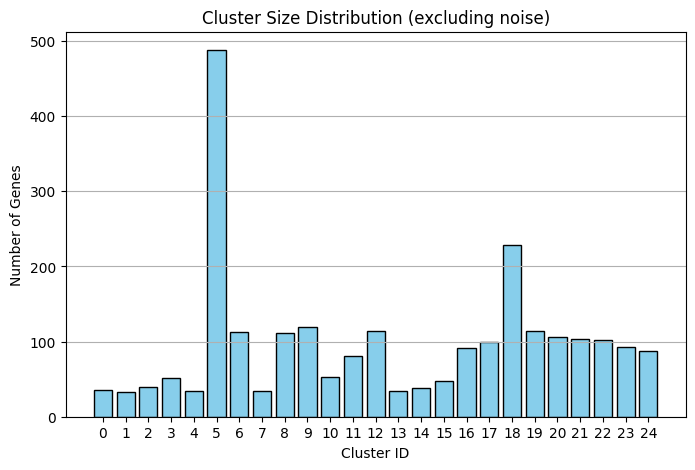

In [ ]:
import matplotlib.pyplot as plt

def plot_cluster_size_distribution(labels):
    mask = labels != -1
    clusters, counts = np.unique(labels[mask], return_counts=True)

    plt.figure(figsize=(8, 5))
    plt.bar(clusters, counts, color='skyblue', edgecolor='black')
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Genes")
    plt.title("Cluster Size Distribution (excluding noise)")
    plt.xticks(clusters)
    plt.grid(axis='y')
    plt.show()
plot_cluster_size_distribution(labels)

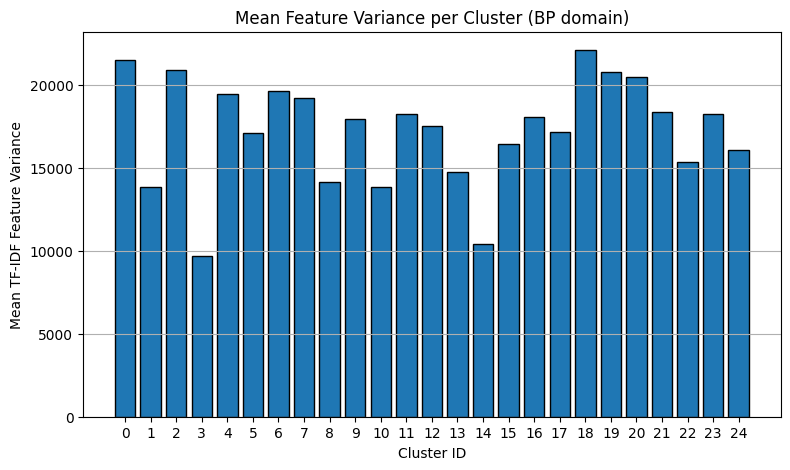

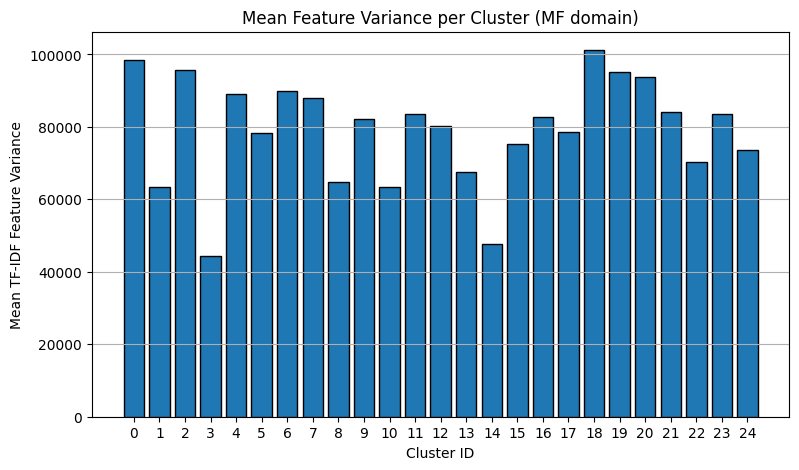

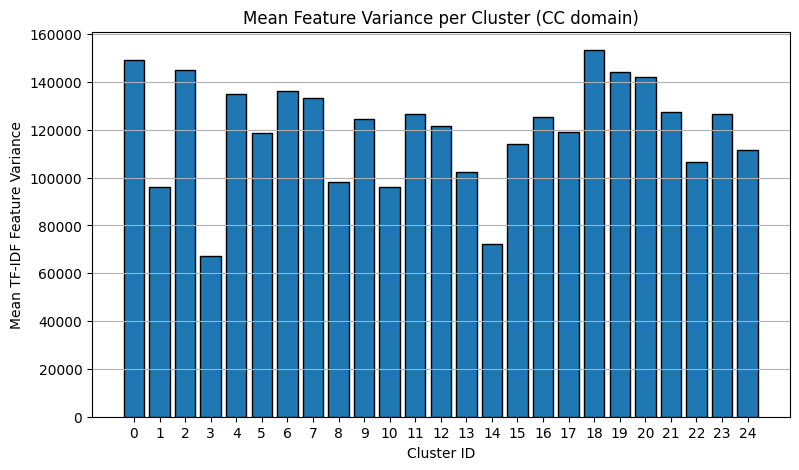

In [ ]:


def plot_cluster_variance(labels, X_tfidf, domain_name="BP"):
    """
    Plot della varianza media delle feature TF-IDF per ciascun cluster.
    labels: vettore dei cluster HDBSCAN
    X_tfidf: matrice TF-IDF (sparse)
    """

    mask = labels != -1
    unique_clusters = np.unique(labels[mask])

    X = X_tfidf.toarray()

    cluster_variances = []

    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        cluster_data = X[idx]

        var = np.var(cluster_data, axis=0).mean()

        cluster_variances.append(var)

    plt.figure(figsize=(9, 5))
    plt.bar(unique_clusters, cluster_variances, edgecolor="black")
    plt.xlabel("Cluster ID")
    plt.ylabel("Mean TF-IDF Feature Variance")
    plt.title(f"Mean Feature Variance per Cluster ({domain_name} domain)")
    plt.xticks(unique_clusters)
    plt.grid(axis="y")
    plt.show()


plot_cluster_variance(labels, X_bp_tfidf, domain_name="BP")
plot_cluster_variance(labels, X_mf_tfidf, domain_name="MF")
plot_cluster_variance(labels, X_cc_tfidf, domain_name="CC")


# <h2> 8. Final Analysis Centroids

In [ ]:
import numpy as np
import pandas as pd

def compute_cluster_centroids(X_tfidf, labels, term_names):
    """
    Calcola i centroidi TF-IDF di ogni cluster.

    Args:
        X_tfidf: matrice sparse CSR (geni × termini)
        labels: vettore etichette cluster HDBSCAN
        term_names: nomi delle colonne (termini GO)

    Ritorna:
        dict: cluster_id -> DataFrame (termine, valore_centroide)
    """
    X = X_tfidf.tocsr()
    unique_clusters = sorted([c for c in set(labels) if c != -1])
    centroids = {}

    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue

        centroid_vec = X[idx].mean(axis=0).A1 
        df = pd.DataFrame({
            'term': term_names,
            'centroid_value': centroid_vec
        }).sort_values(by='centroid_value', ascending=False)

        centroids[c] = df.reset_index(drop=True)

    return centroids


In [37]:
centroids_BP = compute_cluster_centroids(X_bp_tfidf, labels, bp_final.columns)
centroids_MF = compute_cluster_centroids(X_mf_tfidf, labels, mf_final.columns)
centroids_CC = compute_cluster_centroids(X_cc_tfidf, labels, cc_final.columns)


In [38]:
for c, df in centroids_BP.items():
    print(f"\n=== Cluster {c} — Centroide BP ===")
    print(df.head(1))



=== Cluster 0 — Centroide BP ===
         term  centroid_value
0  GO.0022900        2.924807

=== Cluster 1 — Centroide BP ===
         term  centroid_value
0  GO.0006120        4.278797

=== Cluster 2 — Centroide BP ===
         term  centroid_value
0  GO.0045109        3.188561

=== Cluster 3 — Centroide BP ===
         term  centroid_value
0  GO.0006412        3.115315

=== Cluster 4 — Centroide BP ===
         term  centroid_value
0  GO.0007018         3.08685

=== Cluster 5 — Centroide BP ===
         term  centroid_value
0  GO.0006357        1.486843

=== Cluster 6 — Centroide BP ===
         term  centroid_value
0  GO.0030001        2.369596

=== Cluster 7 — Centroide BP ===
         term  centroid_value
0  GO.0030198        3.200224

=== Cluster 8 — Centroide BP ===
         term  centroid_value
0  GO.0006396        2.304016

=== Cluster 9 — Centroide BP ===
         term  centroid_value
0  GO.0006259        2.440842

=== Cluster 10 — Centroide BP ===
         term  centroid_v

In [39]:
for c, df in centroids_MF.items():
    print(f"\n=== Cluster {c} — Centroide MF ===")
    print(df.head(1))

for c, df in centroids_CC.items():
    print(f"\n=== Cluster {c} — Centroide CC ===")
    print(df.head(1))



=== Cluster 0 — Centroide MF ===
         term  centroid_value
0  GO.0009055        2.402387

=== Cluster 1 — Centroide MF ===
         term  centroid_value
0  GO.0008137        4.335513

=== Cluster 2 — Centroide MF ===
         term  centroid_value
0  GO.0030280        2.425623

=== Cluster 3 — Centroide MF ===
         term  centroid_value
0  GO.0003735        3.715034

=== Cluster 4 — Centroide MF ===
         term  centroid_value
0  GO.0045505        2.536599

=== Cluster 5 — Centroide MF ===
         term  centroid_value
0  GO.0140110        1.656281

=== Cluster 6 — Centroide MF ===
         term  centroid_value
0  GO.0005261        2.847707

=== Cluster 7 — Centroide MF ===
         term  centroid_value
0  GO.0030020        4.353101

=== Cluster 8 — Centroide MF ===
         term  centroid_value
0  GO.0003723         2.09488

=== Cluster 9 — Centroide MF ===
         term  centroid_value
0  GO.0003677        1.480979

=== Cluster 10 — Centroide MF ===
         term  centroid_v

In [40]:
df_plot = pd.DataFrame({
    "UMAP1": embedding[:,0],
    "UMAP2": embedding[:,1],
    "cluster": labels
})
df_plot.to_csv("umap_clusters.csv", index=False)


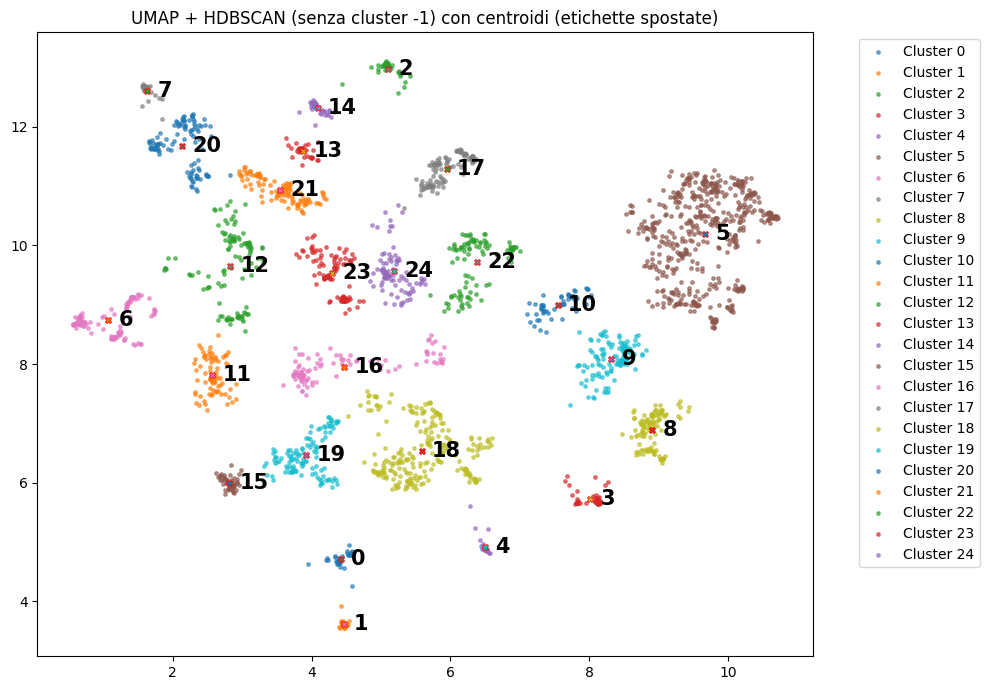

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_centroids_no_noise_offset(embedding, labels, offset=0.15):
    unique_clusters = [c for c in np.unique(labels) if c != -1]

    plt.figure(figsize=(10, 7))

    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        plt.scatter(
            embedding[idx, 0], embedding[idx, 1],
            s=6, alpha=0.6,
            label=f"Cluster {c}"
        )

    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        centroid = embedding[idx].mean(axis=0)

        plt.scatter(
            centroid[0], centroid[1],
            s=20, marker="X", edgecolors="red", linewidth=0.5
        )

        plt.text(
            centroid[0] + offset,
            centroid[1],
            str(c),
            fontsize=15, weight="bold",
            ha='left', va='center'
        )

    plt.title("UMAP + HDBSCAN (senza cluster -1) con centroidi (etichette spostate)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # legenda a lato
    plt.tight_layout()
    plt.show()

plot_centroids_no_noise_offset(embedding, labels)



# <h2> 7. MOFA

In [ ]:
from mofapy2.run.entry_point import entry_point

X_bp = X_bp_tfidf.toarray()
X_mf = X_mf_tfidf.toarray()
X_cc = X_cc_tfidf.toarray()

data = [
    [X_bp],   # view 1
    [X_mf],   # view 2
    [X_cc]    # view 3
]

ent = entry_point()
ent.set_data_matrix(data)



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group

In [ ]:
ent.set_model_options(factors=10) 
ent.set_train_options(iter=5000)


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (view0): gaussian
- View 1 (view1): gaussian
- View 2 (view2): gaussian




In [50]:
ent.build()
ent.run()




######################################
## Training the model with seed 912054 ##
######################################


ELBO before training: -794732671429.18 

Iteration 1: time=9.37, ELBO=-7267051.32, deltaELBO=794725404377.858 (99.99908560%), Factors=10
Iteration 2: time=8.69, ELBO=-6819310.01, deltaELBO=447741.309 (0.00005634%), Factors=10
Iteration 3: time=8.25, ELBO=-6705278.90, deltaELBO=114031.107 (0.00001435%), Factors=10

Converged!



#######################
## Training finished ##
#######################




In [51]:
print(ent.model.__dict__.keys())


dict_keys(['dim', 'nodes', 'options', 'trained', 'simulated', 'train_stats'])


In [52]:
W_all = ent.model.nodes["W"].getExpectation()
print(type(W_all))
print(len(W_all))
for i, w in enumerate(W_all):
    print(i, type(w), np.array(w).shape)


<class 'list'>
3
0 <class 'numpy.ndarray'> (6120, 10)
1 <class 'numpy.ndarray'> (1338, 10)
2 <class 'numpy.ndarray'> (883, 10)


In [ ]:
Z_node = ent.model.nodes["Z"]
F = Z_node.getExpectation()             
print("F shape:", F.shape)

W_all = ent.model.nodes["W"].getExpectation()

W_bp = W_all[0]       # BP
W_mf = W_all[1]       # MF
W_cc = W_all[2]       # CC

print("W_bp shape:", W_bp.shape)
print("W_mf shape:", W_mf.shape)
print("W_cc shape:", W_cc.shape)


F shape: (4166, 10)
W_bp shape: (6120, 10)
W_mf shape: (1338, 10)
W_cc shape: (883, 10)


In [54]:
import umap.umap_ as umap

umap_mofa = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
).fit_transform(F)

print(umap_mofa.shape)


(4166, 2)


In [55]:
import hdbscan

labels_mofa = hdbscan.HDBSCAN(
    min_cluster_size=30,
    metric="euclidean"
).fit_predict(umap_mofa)

print(np.unique(labels_mofa, return_counts=True))


(array([-1,  0,  1]), array([  12,   56, 4098]))


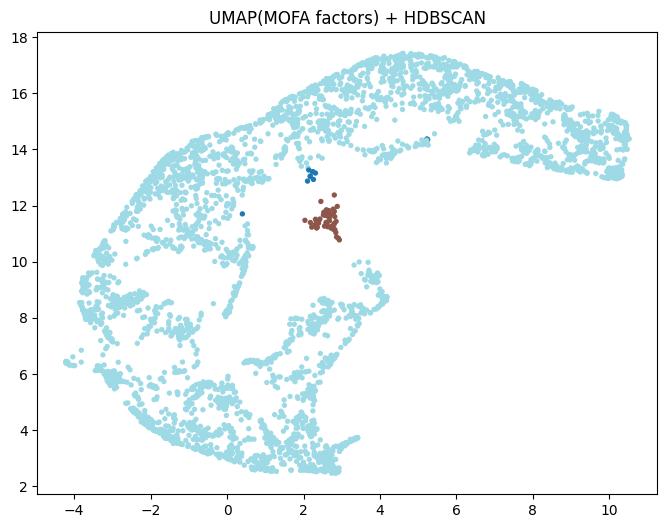

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    umap_mofa[:,0], umap_mofa[:,1],
    c=labels_mofa, cmap='tab20', s=8
)
plt.title("UMAP(MOFA factors) + HDBSCAN")
plt.show()


In [57]:
from sklearn.metrics import silhouette_score

mask = labels_mofa != -1
sil_mofa = silhouette_score(umap_mofa[mask], labels_mofa[mask])

print("Silhouette score MOFA:", sil_mofa)


Silhouette score MOFA: -0.22056154906749725


In [58]:
import pandas as pd

def top_terms_from_loadings(W_matrix, term_names, top_n=20):
    df = pd.DataFrame(W_matrix, columns=[f"F{i}" for i in range(W_matrix.shape[1])])
    df["term"] = term_names
    results = {}
    for f in range(W_matrix.shape[1]):
        df_sorted = df.sort_values(by=f"F{f}", ascending=False)
        results[f] = df_sorted.head(top_n)
    return results

top_bp = top_terms_from_loadings(W_bp, bp_final.columns)
top_mf = top_terms_from_loadings(W_mf, mf_final.columns)
top_cc = top_terms_from_loadings(W_cc, cc_final.columns)

print("=== Top termini per fattore (BP) ===")
for f, df in top_bp.items():
    print(f"\n--- Fattore {f} ---")
    print(df)

print("=== Top termini per fattore (CC) ===")
for f, df in top_cc.items():
    print(f"\n--- Fattore {f} ---")
    print(df)

print("=== Top termini per fattore (MF) ===")
for f, df in top_mf.items():
    print(f"\n--- Fattore {f} ---")
    print(df)


=== Top termini per fattore (BP) ===

--- Fattore 0 ---
               F0          F1        F2         F3         F4         F5  \
0     4789.165587  165.652100 -2.733011  17.386705  42.219534  47.460344   
234      0.047289    0.099365  0.034397  -0.000799  -0.427458   0.162583   
2464     0.046530    0.147439  0.064860   0.095622  -0.720289   0.126864   
1159     0.046477    0.233965  0.226916  -0.024429  -0.594848  -0.380676   
699      0.044947    0.236034 -0.106766  -0.017720  -0.710868  -0.025668   
3636     0.043925    0.204802  0.305835   0.813989  -1.002872  -0.016611   
290      0.043856    0.226059 -0.004506  -0.031106  -0.729833  -0.060911   
297      0.042347    0.172991 -0.001290   0.018305  -0.403153  -0.001410   
1893     0.040441    0.234459  0.332328   1.034751  -1.111288  -0.024509   
1156     0.039228    0.186967  0.362419   1.070619  -1.093245  -0.002845   
4221     0.037708    0.194638  0.340611   0.611467  -0.843114  -0.008400   
263      0.037650    0.146213  0

In [ ]:
F = ent.model.nodes["Z"].getExpectation()  

W_all = ent.model.nodes["W"].getExpectation()
W_bp = W_all[0]    # (6120 × 10)
W_mf = W_all[1]    # (1338 × 10)
W_cc = W_all[2]    # (883  × 10)


In [ ]:
import numpy as np

def explained_variance(F, W):
    """
    Calcola la varianza spiegata dai fattori per una singola view.
    
    Args:
        F: (n_genes × n_factors)
        W: (n_features × n_factors)
    Returns:
        var_per_factor: array con varianza spiegata da ciascun fattore
    """
    K = F.shape[1] 
    var = np.zeros(K)

    for k in range(K):
        reconstructed = np.outer(F[:, k], W[:, k])  
        var[k] = np.var(reconstructed)

    return var


In [61]:
var_bp = explained_variance(F, W_bp)
var_mf = explained_variance(F, W_mf)
var_cc = explained_variance(F, W_cc)


In [62]:
var_total = var_bp + var_mf + var_cc
print("Varianza totale per fattore:", var_total)


Varianza totale per fattore: [2.59823587e+05 3.31711790e+01 6.30282377e-03 3.59673241e-02
 2.84321824e-01 3.73289980e-01 1.06138436e-02 1.91658944e-03
 2.32670572e-03 2.07777156e-02]


In [63]:
indices = np.argsort(var_total)[::-1]

print("Fattori ordinati per importanza:")
for i in indices:
    print(f"Factor {i}: total variance = {var_total[i]:.4f}")


Fattori ordinati per importanza:
Factor 0: total variance = 259823.5867
Factor 1: total variance = 33.1712
Factor 5: total variance = 0.3733
Factor 4: total variance = 0.2843
Factor 3: total variance = 0.0360
Factor 9: total variance = 0.0208
Factor 6: total variance = 0.0106
Factor 2: total variance = 0.0063
Factor 8: total variance = 0.0023
Factor 7: total variance = 0.0019


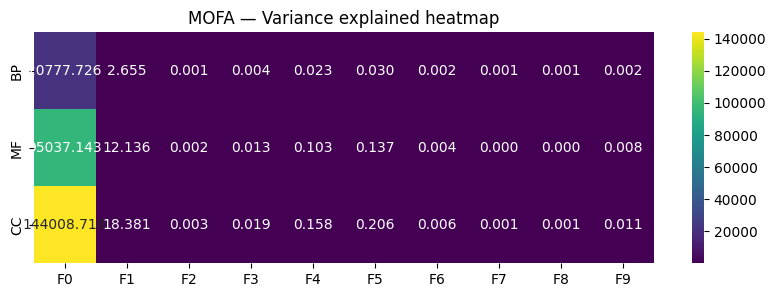

In [ ]:
import seaborn as sns
import numpy as np

mat = np.vstack([var_bp, var_mf, var_cc])  
views = ["BP", "MF", "CC"]

plt.figure(figsize=(10,3))
sns.heatmap(mat, cmap="viridis", annot=True, fmt=".3f",
            xticklabels=[f"F{i}" for i in range(len(var_total))],
            yticklabels=views)
plt.title("MOFA — Variance explained heatmap")
plt.show()


In [65]:
import pandas as pd
import numpy as np

def top_loadings(W_matrix, feature_names, top_n=20):
    """
    Estrae i top-N termini per ogni fattore (colonne del loading matrix).
    
    W_matrix: (n_features × n_factors)
    feature_names: lista nomi dei termini GO
    """
    results = {}
    n_factors = W_matrix.shape[1]

    for f in range(n_factors):
        col = W_matrix[:, f]
        top_idx = np.argsort(np.abs(col))[::-1][:top_n]
        terms = [(feature_names[i], col[i]) for i in top_idx]
        results[f] = terms

    return results


In [66]:
top_bp = top_loadings(W_bp, bp_final.columns, top_n=5)
top_mf = top_loadings(W_mf, mf_final.columns, top_n=5)
top_cc = top_loadings(W_cc, cc_final.columns, top_n=5)


In [67]:
for f in range(10):
    print(f"\n=== BP — Fattore {f} ===")
    for term, weight in top_bp[f][1:6]:
        print(f"  {term}: {weight:.4f}")

    print(f"=== MF — Fattore {f} ===")
    for term, weight in top_mf[f][1:6]:
        print(f"  {term}: {weight:.4f}")

    print(f"=== CC — Fattore {f} ===")
    for term, weight in top_cc[f][1:6]:
        print(f"  {term}: {weight:.4f}")



=== BP — Fattore 0 ===
  GO.0009725: 0.0473
  GO.0033993: 0.0465
  GO.0007166: 0.0465
  GO.0042127: 0.0449
=== MF — Fattore 0 ===
  GO.0038023: 0.0402
  GO.0004888: 0.0390
  GO.0005102: 0.0388
  GO.0042802: 0.0325
=== CC — Fattore 0 ===
  GO.0070062: 0.0574
  GO.0098797: 0.0441
  GO.0030141: 0.0383
  GO.0043235: 0.0376

=== BP — Fattore 1 ===
  GO.0045595: 0.2667
  GO.0022008: 0.2508
  GO.0030182: 0.2467
  GO.0045597: 0.2377
=== MF — Fattore 1 ===
  GO.0005102: 0.2131
  GO.0000987: 0.1898
  GO.0022857: -0.1837
  GO.0015075: -0.1836
=== CC — Fattore 1 ===
  GO.0098687: -0.1302
  GO.0009986: 0.1201
  GO.0000781: -0.1072
  GO.1902495: -0.1023

=== BP — Fattore 2 ===
  GO.0006811: 1.2139
  GO.0034220: 1.1788
  GO.0006812: 1.1602
  GO.0042391: 1.1337
=== MF — Fattore 2 ===
  GO.0015075: 1.0824
  GO.0140110: -1.0577
  GO.0003677: -1.0306
  GO.0022857: 1.0288
=== CC — Fattore 2 ===
  GO.0045202: 1.0740
  GO.0098796: 1.0605
  GO.0000785: -1.0406
  GO.0098590: 1.0242

=== BP — Fattore 3 ===
  

In [68]:
def top_genes_per_factor(F, gene_ids, top_n=5):
    results = {}
    n_factors = F.shape[1]

    for f in range(n_factors):
        col = F[:, f]
        top_idx = np.argsort(np.abs(col))[::-1][:top_n]
        results[f] = [(gene_ids[i], col[i]) for i in top_idx]

    return results


In [69]:
top_genes = top_genes_per_factor(F, bp_final["id"].values)
for f in range(10):
    print(f"\n=== Fattore {f} — Top geni ===")
    for gene_id, weight in top_genes[f]:
        print(f"  {gene_id}: {weight:.4f}")
  



=== Fattore 0 — Top geni ===
  5171: -4.4816
  5169: -4.4749
  5168: -4.4701
  5166: -4.4673
  5165: -4.4642

=== Fattore 1 — Top geni ===
  2346: 1.0303
  506: 1.0123
  172: -1.0056
  182: -1.0027
  1522: 1.0016

=== Fattore 2 — Top geni ===
  220: -2.1752
  1522: -2.1643
  616: 2.0599
  2074: -1.9561
  3701: 1.7009

=== Fattore 3 — Top geni ===
  1522: -2.3092
  506: -2.0503
  220: -1.9084
  1989: -1.7293
  2074: -1.4976

=== Fattore 4 — Top geni ===
  1101: -1.8228
  2230: -1.6937
  3555: -1.6322
  2235: -1.6303
  1112: -1.5626

=== Fattore 5 — Top geni ===
  2568: -1.2457
  2250: 1.2455
  3133: -1.0056
  1577: -0.9743
  1833: -0.9259

=== Fattore 6 — Top geni ===
  73: 2.0510
  3555: -1.7311
  119: 1.5784
  642: 1.3287
  2235: 1.2383

=== Fattore 7 — Top geni ===
  616: -15.0940
  297: 15.0876
  1440: 12.4393
  2253: 12.4063
  1439: 12.2683

=== Fattore 8 — Top geni ===
  4726: 8.6837
  3453: 8.3149
  1602: 8.0708
  3368: 7.8368
  2568: -6.5135

=== Fattore 9 — Top geni ===
  220: